#1. Experiment design

В этом тесте я проверяю, насколько возможно увеличение степени конверсии (то есть, оплаты посетителем сайта) при внедрении
нового механизма оплаты на 28.75 % в абсолютном выражении. Почему я так делаю: так как обычно, внедряя новый 
элемент продукта, менеджер держит в голове конкретный процент, на который, на его взгляд, увеличится приток клиентов. К тому же,
так удобнее оценить результат внедрения нового элемента, а еще - подобрать оптимальный размер sample.

Поскольку в случае тестового задания не было никакого таргета, я действовала от обратного: подбирала такой процент увеличения
конверсии, при котором я смогу провести a/b тест. Остановилась на 28.75%.

#2. Formulating a hypothesis
АБ тест предназначен для проверки гипотезы. Гипотеза нужна для того, чтобы наша интерпретация результатов
была верной. 
Поскольку мы не знаем заранее, покажет ли новый механизм оплаты себя лучше, чем нынешний,
мы выбираем two-tailed test:
Hₒ: p = pₒ
Hₐ: p ≠ pₒ
где p - процент конверсии нового механизма, и pₒ - старого. Я выбрала confidence interval 95%:
α = 0.05
Что это значит: какой бы процент конверсии мы ни будем наблюдать для нового механизма оплаты, мы хотим быть на 95% уверены что он статистически отличен от процента конверсии старого механизма оплаты перед тем, как мы решим отвергнуть нулевую гипотезу.

#3 Выбирая переменные
Для теста нам нужны две группы: контрольная и экспериментальная. Они даны нам изначально в тестовом задании.

Они - наши независимые переменные. Нам нужны две группы несмотря на то, что мы знаем базовый процент конверсии проста:
мы хотим убедиться, что другие переменные не отразятся на результатах, и мы увидим только эффект внедрения нового механизма оплаты.  

Зависимая переменная, которую мы пытаемся измерить, - процент конверсии. 
Для расчетов я добавила столбец conversion, которая принимает значения: 
0 - Пользователь не купил продукт в течении срока эксперимента
1 - Пользователь купил его.



#4 Размер выборки в каждой группе
Определила через Power analysis, он зависит от нескольких факторов:
Power of the test (1 — β) — вероятность нахождения статистической разницы между группами когда эта разница дейстительно существует.  Обычно, выбирают 0.8, также поступила и я.
Alpha value (α) — Критическое значение, у нас равняется 0.05.
Effect size — Насколько большую разницу мы ожидаем обнаружить между процентами конверсии. 

#5 Метрики
В ходе теста я смотрела на процент конверсии (а не на средний чек, например) потому, что врядли новый механизм оплаты сам по себе стимулировал потребителей увеличивать размер покупок. Он влиял лишь на принятие решения, купить ли товар именно на этом сайте, у этой компании.

In [89]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)
effect_size = sms.proportion_effectsize(0.057, 0.085)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

import os
print(os.getcwd())


1309
C:\Users\Hp


In [74]:
import numpy as np
import pandas as pd
df = pd.read_csv('table.csv')
df.head()

,id,group,check,converted,payment_way
0,581585,A,0.0,0,old
1,5723133,A,0.0,0,old
2,3276743,B,0.0,0,new
3,4238589,A,0.0,0,old
4,4475369,B,0.0,0,new


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           8341 non-null   int64  
 1   group        8341 non-null   object 
 2   check        8341 non-null   float64
 3   converted    8341 non-null   int64  
 4   payment_way  8341 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 325.9+ KB


In [75]:
# To make sure all the control group are seeing the old page and viceversa

pd.crosstab(df['group'], df['payment_way'])

payment_way,new,old
group,,
A,0,1538
B,6803,0


In [77]:
#This part potentially detects the duplicate users
session_counts = df['id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 0 users that appear multiple times in the dataset


In [78]:
#This part potentially removes the duplicate users
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 8341 entries


In [90]:
control_sample = df[df['group'] == 'A'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'B'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,id,group,check,converted,payment_way
0,3594801,A,0.0,0,old
1,3531923,A,0.0,0,old
2,3289748,A,0.0,0,old
3,4347916,A,690.0,1,old
4,4016303,A,0.0,0,old
...,...,...,...,...,...
2613,3806972,B,0.0,0,new
2614,1019016,B,0.0,0,new
2615,256894,B,0.0,0,new
2616,4630766,B,0.0,0,new


In [91]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2618 entries, 0 to 2617
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           2618 non-null   int64  
 1   group        2618 non-null   object 
 2   check        2618 non-null   float64
 3   converted    2618 non-null   int64  
 4   payment_way  2618 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 102.4+ KB


In [92]:
ab_test['group'].value_counts()

B    1309
A    1309
Name: group, dtype: int64

In [93]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
A,0.050,0.219,0.006
B,0.036,0.186,0.005


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


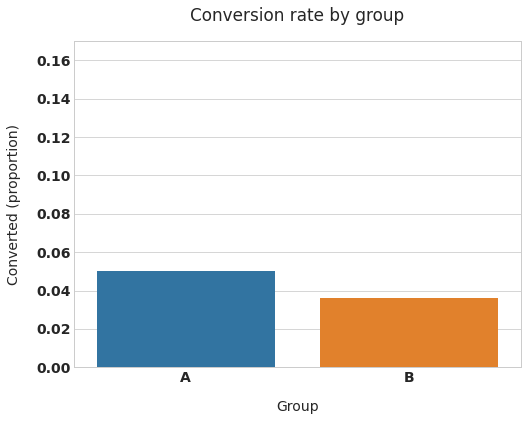

In [94]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

#6 Получается, процент конверсии при старом механизме оплаты определенно выше. Надо проверить, значим ли статистически этот результат

In [96]:
#7 Testing the hypothesis

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = ab_test[ab_test['group'] == 'A']['converted']
treatment_results = ab_test[ab_test['group'] == 'B']['converted']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.83
p-value: 0.068
ci 95% for control group: [0.039, 0.062]
ci 95% for treatment group: [0.026, 0.046]


#Conclusions
Поскольку p-value=0.068, и эта цифра выше α=0.05, но не слишком- то мы не можем отвергнуть нулевую гипотезу Hₒ (с точки зрения статистики, старый механизм немногим лучше нового). Для более точных результатов нужна большая выборка.
